# Weather analysis for San Francisco
## Data from NOAA

In [1]:
import collections
import urllib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

##  Gather the files from the NOAA website and understand its structure

In [2]:
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt', 'readme.txt')

('readme.txt', <http.client.HTTPMessage at 0x1b95d9ffdd8>)

In [3]:
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt', 'stations.txt')

('stations.txt', <http.client.HTTPMessage at 0x1b95da252e8>)

    FORMAT OF "ghcnd-stations.txt"

    ------------------------------
    Variable   Columns   Type
    ------------------------------
    ID            1-11   Character
    LATITUDE     13-20   Real
    LONGITUDE    22-30   Real
    ELEVATION    32-37   Real
    STATE        39-40   Character
    NAME         42-71   Character
    GSN FLAG     73-75   Character
    HCN/CRN FLAG 77-79   Character
    WMO ID       81-85   Character
    ------------------------------


In [4]:
# loading a fixed-width text file: we prescribe the widths of every field;
# the names of the resulting array columns; their datatypes. 'Uxx' stands
# for unicode string of length xx; 'd' for double precision floating point

stations = np.genfromtxt('stations.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                         names=['id','latitude','longitude','elevation','state','name',
                                                'gsn','hcn','wmo'],
                                         dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                         autostrip=True)

In [5]:
len(stations)

115082

In [6]:
stations

array([('ACW00011604',  17.1167, -61.7833,   10.1, '', 'ST JOHNS COOLIDGE FLD', '', '', ''),
       ('ACW00011647',  17.1333, -61.7833,   19.2, '', 'ST JOHNS', '', '', ''),
       ('AE000041196',  25.333 ,  55.517 ,   34. , '', 'SHARJAH INTER. AIRP', 'GSN', '', '41196'),
       ...,
       ('ZI000067977', -21.017 ,  31.583 ,  430. , '', 'BUFFALO RANGE', '', '', '67977'),
       ('ZI000067983', -20.2   ,  32.616 , 1132. , '', 'CHIPINGE', 'GSN', '', '67983'),
       ('ZI000067991', -22.217 ,  30.    ,  457. , '', 'BEITBRIDGE', '', '', '67991')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

## Visualize the station locations on map

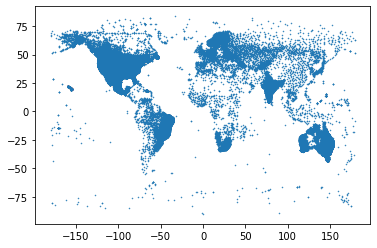

In [7]:
pp.plot(stations['longitude'], stations['latitude'], '.', markersize=1)

In [8]:
stations_ca = stations[stations['state'] == 'CA']

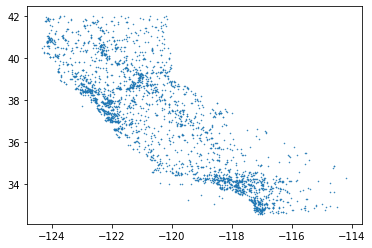

In [9]:
pp.plot(stations_ca['longitude'], stations_ca['latitude'], '.', markersize=1)

In [10]:
stations[stations['name'] == 'SAN FRANCISCO']

array([('MXN00007145', 15.8667, -92.95,  539.8, '', 'SAN FRANCISCO', '', '', ''),
       ('MXN00024066', 22.0667, -99.85, 1012.9, '', 'SAN FRANCISCO', '', '', ''),
       ('MXN00028204', 24.9667, -98.3 ,   44.8, '', 'SAN FRANCISCO', '', '', ''),
       ('MXN00028222', 23.3833, -98.8 ,  524. , '', 'SAN FRANCISCO', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [11]:
stations[np.char.find(stations['name'], 'SAN FRANCISCO') == 0]

array([('MXN00001025', 22.0667, -102.2667, 1.8797e+03, '', 'SAN FRANCISCO DE LOS ROMO (SM', '', '', ''),
       ('MXN00001035', 21.9   , -102.1167, 2.0199e+03, '', 'SAN FRANCISCO DE LOS VIVEROS', '', '', ''),
       ('MXN00001083', 22.0667, -102.2667, 1.9090e+03, '', 'SAN FRANCISCO DE LOS ROMO (DG', '', '', ''),
       ('MXN00003191', 27.5833, -113.0167, 1.0799e+03, '', 'SAN FRANCISCO DE LA SIERRA', '', '', ''),
       ('MXN00005157', 26.8167, -102.7167, 8.9980e+02, '', 'SAN FRANCISCO DEL VALLE', '', '', ''),
       ('MXN00005164', 27.1333, -101.65  , 4.9990e+02, '', 'SAN FRANCISCO NADADORES', '', '', ''),
       ('MXN00007145', 15.8667,  -92.95  , 5.3980e+02, '', 'SAN FRANCISCO', '', '', ''),
       ('MXN00008123', 27.8833, -106.7   , 1.6639e+03, '', 'SAN FRANCISCO DE BORJA (DGE)', '', '', ''),
       ('MXN00008188', 27.9   , -106.6833, 1.6398e+03, '', 'SAN FRANCISCO DE BORJA (SMN)', '', '', ''),
       ('MXN00009041', 19.1833,  -99.1167, 2.6198e+03, '', 'SAN FRANCISCO TLALNEPANTLA', 

## Obtain the San Francisco data file from the website

In [12]:
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USW00023272.dly', 'SANFRANCISCO.dly')

('SANFRANCISCO.dly', <http.client.HTTPMessage at 0x1b9657345f8>)

In [13]:
# read the file and format the data as required for the analysis
def get_data(station_file):
    w = np.genfromtxt(station_file,
                      delimiter=[11,4,2,4] + [5,1,1,1]*31,
                      usecols=[0,1,2,3] + list(range(4,4*32,4)),
                      names=['id','year','month','element'] + [f'day{i}' for i in range(1,32)],
                      dtype=['U11','i','i','U4'] + ['d']*31,
                      autostrip=True)
    pw = pd.DataFrame(w)

    # "melt" the daily observations into one record per daily observation, storing the column name in 'day'
    pw = pd.melt(pw, id_vars=['id','year','month','element'], var_name='day', value_name='value')
    
    # remove null observations
    pw = pw[pw.value != -9999]

    # keep only min/max temperatures, precipitation, and snow
    pw = pw[pw.element.isin(['TMAX','TMIN','PRCP','SNOW'])]

    # convert 'day1', 'day2', etc. to the number of the day 
    pw['day'] = pw.day.apply(lambda x: int(x[3:]))
    
    # make a date out of year, month, day
    pw['date'] = pd.to_datetime(pw[['year','month','day']])

    # keep only data, element, and value
    pw = pw[['date','element','value']]

    # restructure the DataFrame so that different elements for the same day appear in the same row
    pw = pw.pivot(index='date', columns='element')['value']
    pw.columns.name = None    
    pw = pw[['TMIN','TMAX','PRCP','SNOW']]
    
    # convert temperatures to degrees
    pw['TMIN'] /= 10.0
    pw['TMAX'] /= 10.0
    return pw

In [14]:
# get the records for a given year and given columns based on the filename
def get_year(station_file, elements, year):
        
    alldata = get_data(station_file)
    
    # select data by year, and get rid of the extra day in leap years, then select the "element" column
    yeardata = alldata[(alldata.index.year == year) & (alldata.index.dayofyear < 366)]
    
    # make an empty record array full of nans
    data = np.full(365, np.nan, dtype=[(element, np.float64) for element in elements])
    
    for element in elements:    
        # fill it with values, using day of the year (1 to 365) as index
        data[element][yeardata.index.dayofyear - 1] = yeardata[element].values
    
    return data

In [15]:
sf_data = get_year('SANFRANCISCO.dly', ['TMIN','TMAX'], 2000)

In [16]:
# fill NaNs in any array by interpolation
def fillnans(array):
    good = ~np.isnan(array)
    x = np.arange(len(array))

    return np.interp(x, x[good], array[good])

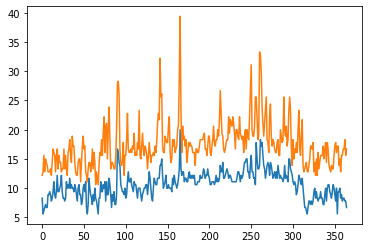

In [17]:
pp.plot(fillnans(sf_data['TMIN']))
pp.plot(fillnans(sf_data['TMAX']))

In [18]:
sf_data['TMIN'] = fillnans(sf_data['TMIN'])
sf_data['TMAX'] = fillnans(sf_data['TMAX'])

In [19]:
mean, err = np.mean(sf_data['TMIN']), math.sqrt(np.var(sf_data['TMIN']))

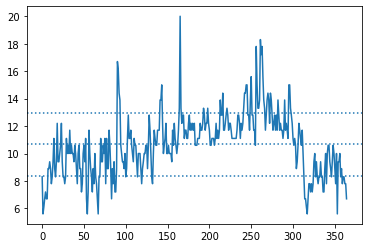

In [20]:
pp.plot(sf_data['TMIN'])

# plot horizontal lines at mean, mean - std error, and mean + std error
for value in [mean, mean - err, mean + err]:
    pp.axhline(value, linestyle=':')

In [21]:
# for records get TMIN/TMAX arrays for years 1910-2018
allyears = np.vstack([get_year('SANFRANCISCO.dly', ['TMIN','TMAX'], year)
                      for year in range(1910, 2019)])

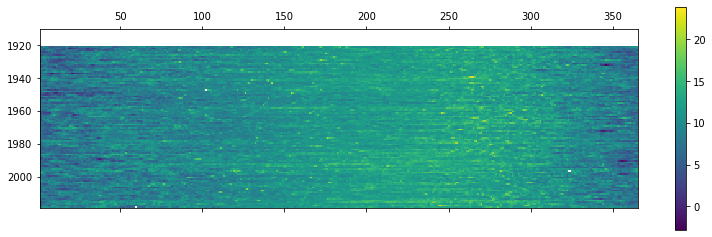

In [22]:
# show stacked array as colored map, specifying axis values,
pp.matshow(allyears['TMIN'], extent=[1,365,2019,1910])
pp.colorbar()

In [23]:
# min and max of TMIN/TMAX along all years, excluding NaNs
tmin_record = np.nanmin(allyears['TMIN'], axis=0)
tmax_record = np.nanmax(allyears['TMAX'], axis=0)

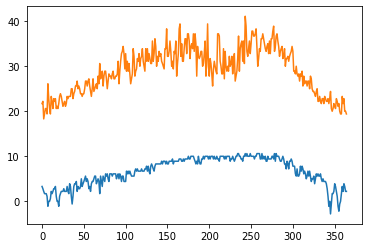

In [24]:
pp.plot(tmin_record)
pp.plot(tmax_record)

In [25]:
# for normals: get TMIN/TMAX arrays for years 1981-2010, stack vertically in array
normal = np.vstack([get_year('SANFRANCISCO.dly', ['TMIN','TMAX'], year)
                    for year in range(1981, 2011)])

In [26]:
# mean of TMIN/TMAX across 1981-2010 years, excluding NaNs
tmin_normal = np.nanmean(normal['TMIN'], axis=0)
tmax_normal = np.nanmean(normal['TMAX'], axis=0)

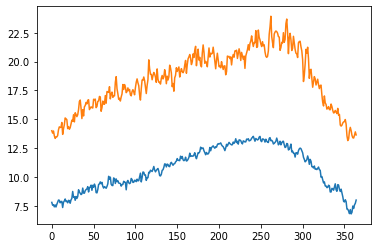

In [27]:
pp.plot(tmin_normal)
pp.plot(tmax_normal)

In [28]:
file, year = 'SANFRANCISCO.dly', 2018
thisyear = get_year(file, ['TMIN', 'TMAX'], year)

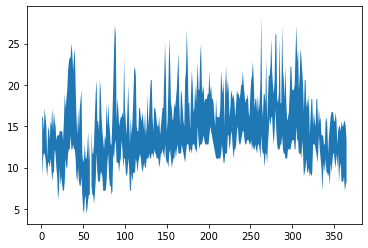

In [29]:
# fill area between horizontal curves (days, thisyear['TMIN']) and (days, thisyear['TMAX'])
days = np.arange(1, 366)
pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'])

In [30]:
# calculate average temperature
avg = 0.5*(np.nanmean(thisyear['TMIN']) + np.nanmean(thisyear['TMAX']))

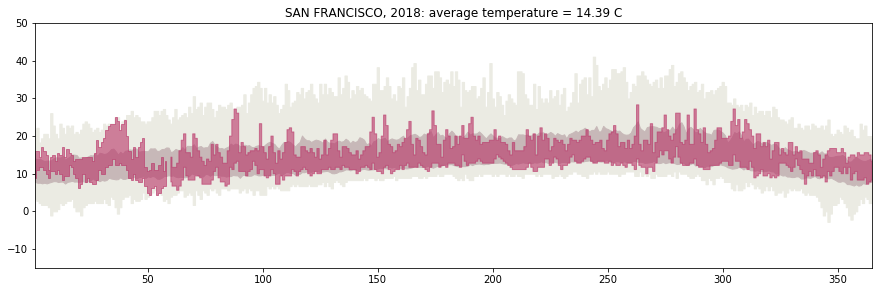

In [31]:
# show normals, records, and current year bands together
station = "SAN FRANCISCO"
pp.figure(figsize=(15,4.5))

pp.fill_between(days, tmin_record, tmax_record, color=(0.92,0.92,0.89), step='mid')
pp.fill_between(days, tmin_normal, tmax_normal, color=(0.78,0.72,0.72))

pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'],
                color=(0.73,0.21,0.41), alpha=0.6, step='mid')

pp.axis(xmin=1, xmax=365, ymin=-15, ymax=50)

pp.title(f'{station}, {year}: average temperature = {avg:.2f} C');

## Analyze the temperature difference
### Comparing the average temperature from 1880-2019 with the average temperature over 1945-1955

In [32]:
def cal_mean(station_file, year):
    data = get_year(station_file, ['TMIN','TMAX'], year)
    return np.nanmean(0.5 * (data['TMIN'] + data['TMAX'])) 

In [34]:
station_file = 'SANFRANCISCO.dly'
normal = np.vstack([get_year(station_file, ['TMIN','TMAX'], year)
                        for year in range(1945, 1955)])
decade_mean = np.nanmean(0.5 * (normal['TMIN'] + normal['TMAX']))
mean_by_year = np.array([cal_mean(station_file, year) for year in range(1880, 2020)])
diff = mean_by_year - decade_mean

C:\Users\vardh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


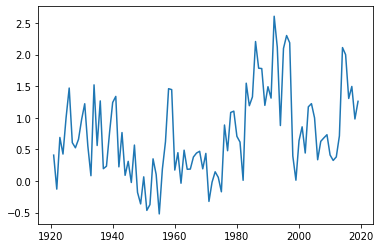

In [42]:
pp.plot(range(1880, 2020), diff)